# Intent Analysis on chat bot data

Chat bots are increasingly used to automate online customer queries and negate the need for call center staff.

Here we will train a Long Short Term Memory (LSTM) network to suggest the intent of a customer based on the text of the input query.

[LSTM](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470) networks are great for text classification problems because they have memory (e.g. would be able to identify the word "not" before "good" as a negative sentiment). This sequential context is something that humans take for granted but that is very difficult for computers to grasp.


In [7]:
#import dependencies
import pandas as pd
import keras
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import utils

# Load train and test sample

We will load separately the train and test data. The Xtrain and ytrain respectively will contain a list of the query (one list element per sample) and the outcome label (16 possibilities).

In [8]:
#intent analysis atis dataset 
dftrain = pd.read_csv('./data/datasets_117486_281522_atis.train.csv')
Xtrain, ytrain = list(dftrain.values[:,1]), list(dftrain.values[:,-1])

dftest = pd.read_csv('./data/datasets_117486_281522_atis.test.csv')
Xtest, ytest = list(dftest.values[:,1]), list(dftest.values[:,-1])

# One-hot encode labels

We will be predicting the probability that an input beloings to each class. For each label, we therefore need a vector of 1s and 0s where 1 appears next to the correct label, and all incorrect labels are zero.

In [9]:
#one hot encode labnels
ytrain = pd.get_dummies(ytrain)
labels = list(ytrain.columns)
nlabels = len(labels)
ytrain = np.array(ytrain)
ytest = pd.get_dummies(ytest)
ytest = np.array(ytest)

# Tokenization

We now map each word to an integer identifier. The list sample is then converted into a vector of integers corresponding to each word. For shorter inputs, we padd the start with zeros so that each sample has the same input vector length. 

Since there are so many words collectively in the full dataset, we keep only the 50 most common in each sample to avoid overfitting our classifier.

In [10]:
#convert all abstracts to sequences of integers key stored in idx_word
tokenizer = keras.preprocessing.text.Tokenizer(num_words=50,
                                               filters="?!':;,.#$&()*+-<=>@[\\]^_`{|}~\t\n",
                                               lower=True, split=' ')
tokenizer.fit_on_texts(Xtrain)
#assign an integer ID to each word
Xtrain_sequence = tokenizer.texts_to_sequences(Xtrain)
#padd the sequences of short sentences with 0s so everything is the same length
Xtrain_sequence = keras.preprocessing.sequence.pad_sequences(Xtrain_sequence,
                                                             padding='post')

#record the word to ID map and count the number of words in our vocabulary (+ 1 as we have the 0 padding as a word)
idx_word = tokenizer.index_word
num_words = len(idx_word) + 1

# Word Embeddings

We need a mathematical way to represent 'words' in vector form such that words with similar meaning have vectors that point in similar directions. i.e. "plant" and "flower" would have similar pointing vectors in this abstract "Embedding Vector Space", but that vectors for words like "Hot" and "Cold" would point in opposite directions. Training these word embeddings is a herculean task even with monstrous amounts of computing power (not at all suitable for a Macbook). Fortunately, we can load a pre-trained word embedding dictionary like GloVe. GloVe is an unsupervised learning algorithm for representing words as vectors. In this representation, the cosine angle between two word vectors provides an effective method for measuring the linguistic or semantic similarity of the corresponding words as required. GloVe includes several pre-trained word embedding vocabularies. This work uses the 100d vector version with a vocabulary size of 400,000. 

In [11]:
#load in word embeddings
embeddings_dict = utils.load_embeddings('../disaster_nlp/data/non_tracked/glove.6B.100d.txt')
embeddings_words = list(embeddings_dict.keys())
wordvec_dim = embeddings_dict[embeddings_words[0]].shape[0]
embedding_matrix = np.zeros((num_words,wordvec_dim))
for i, word in idx_word.items():
    # Look up the word embedding
    vector = embeddings_dict.get(word, None)
    # Record in matrix
    if vector is not None:
        embedding_matrix[i, :] = vector

# Fit the model

We now build the LSTM model. Many neural nets share similar features. If we want to assign the probability to each class of a given input, the output will always be a Dense layer with softmax activation function equal to the number of labels. If we want a positive / negative decision, the output will be a single neuron with a sigmoid loss. The differences with LSTMs are the input 'Embedding' layer, where we specify our newly loaded word embeddings, and the number of input training samples and size of our vocabulary.

In [12]:
#Initialise the usual sequential network
model_lstm = keras.Sequential()

#initialise Ebedding layer
# input_length is the number of words ids per sample e.g 28
# NOT the sample size of the training data
# you do not need to supply that info
model_lstm.add(keras.layers.Embedding(input_dim=num_words,
                                      input_length=Xtrain_sequence.shape[1],
                                      output_dim=wordvec_dim,
                                      weights=[embedding_matrix],
                                      trainable=False,
                                      mask_zero=True))

#words which are not in the pretrained embeddings (with value 0) are ignored
model_lstm.add(keras.layers.Masking(mask_value = 0.0))

# Recurrent layer
model_lstm.add(keras.layers.LSTM(64, activation='relu'))

# Dropout for regularisation and avoid overfit
model_lstm.add(keras.layers.Dropout(0.5))

# Output layer
model_lstm.add(keras.layers.Dense(nlabels,activation = 'softmax' ))

# Compile the model
model_lstm.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarise the model
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 100)           86500     
_________________________________________________________________
masking_1 (Masking)          (None, 28, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                1105      
Total params: 129,845
Trainable params: 43,345
Non-trainable params: 86,500
_________________________________________________________________


# Fit the model to the training data

In [13]:
model_lstm.fit(Xtrain_sequence, ytrain,epochs=5)

Epoch 1/5
4274/4274 [==============================] - 3s 797us/step - loss: 1.1661 - accuracy: 0.7270
Epoch 2/5
4274/4274 [==============================] - 3s 643us/step - loss: 0.8077 - accuracy: 0.7829
Epoch 3/5
4274/4274 [==============================] - 3s 629us/step - loss: 0.6993 - accuracy: 0.8189
Epoch 4/5
4274/4274 [==============================] - 3s 655us/step - loss: 0.6262 - accuracy: 0.8320
Epoch 5/5
4274/4274 [==============================] - 3s 659us/step - loss: 0.5659 - accuracy: 0.8503


# Transform the test data using the tokenizer and evaluate the model performance

In [14]:
#Transform the test data
Xtest_sequence = tokenizer.texts_to_sequences(Xtest)
Xtest_sequence = keras.preprocessing.sequence.pad_sequences(Xtest_sequence,
                                                            maxlen = Xtrain_sequence.shape[1],
                                                            padding='post')

In [15]:
#evaluate model performance
eval_lstm = model_lstm.evaluate(Xtest_sequence, ytest)
ypred = model_lstm.predict(Xtest_sequence)

586/586 [==============================] - 0s 380us/step


# Convert Class probabilities into predictions

For simplicity we simply take the class with the largest probability to be the prediction

In [17]:
#multiclass problem, pick highest probability as the choice
ypred_choices = ypred*0
cnt = 0
for yp in ypred:
    idx = np.argmax(yp)
    ypred_choices[cnt,idx] = 1
    cnt += 1

# Confusion Matrix Performance Analysis

Here we see where the classifier performs well and where any mis-classifications are most common. Given we have an class abundance bias, the normalised confusion matrix is plotted below.

In [ ]:
#construct multilabel confusion matrix
import matplotlib.pylab as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(ytest.argmax(axis=1), ypred_choices.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(xticks_rotation=90,cmap='Blues')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

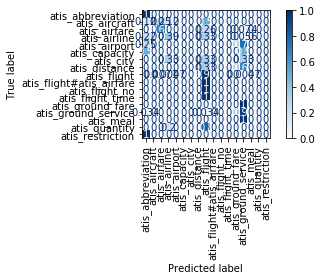

In [21]:
#construct multilabel confusion matrix
import matplotlib.pylab as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(ytest.argmax(axis=1), ypred_choices.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(xticks_rotation=90,cmap='Blues')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()